# Pipeline 2: DW-To-Google pipeline

The aim of this notebook is to be able to answer the questions: How timely are DW articles?

Approach: Extract importnat DW keywords, see how they fluctuate in time and compare to Google searches

<img src="../reports/illustrations/pipeline2.png" width=800 />

In [10]:
# Import useful libraries
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt

# Import functions from source folder
sys.path.append('../src/') 
from data.preprocess_keywords import make_cleaned_keywords_df
from data.make_datasets import get_data, get_interest_over_time, get_dw_timeseries
from visualization.visualize import plot_signals

In [20]:
# Specify keyword of interest
keyword = 'angela merkel'

# Specify wanted time range
start_date = '2019-01-01'
end_date = '2022-01-01'

# Get google data for a specific keyword

In [21]:
google_df = get_interest_over_time(keyword, start_date, end_date)

/home/magda_d/venv/lib64/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/magda_d/venv/lib64/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/magda_d/venv/lib64/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/m

# Load DW data

In [22]:
# Clean data file in specific date range
clean_data_file = '../data/interim/clean_keywords_' + start_date + '_' + end_date + '.json'

# Generates the clean data file if it does not exist
if os.path.isfile(clean_data_file) == False:

    # Path to raw data
    data_file = '../data/raw/CMS_2010_to_June_2022_ENGLISH.json'

    # Load and extract data within time range
    df_subset = get_data(data_file, start_date, end_date)

    # Cleans keywords and saves data as a dataframe
    make_cleaned_keywords_df(df_subset, start_date, end_date)


# Loads the clean data file
df_dw = pd.read_json(clean_data_file, orient ='split', compression = 'infer')

# Get DW mentions binned into the google dates output 
mixed_df = get_dw_timeseries(df_dw, keyword, google_df, start_date = start_date)

# Compare between DW trends for this keyword and Google

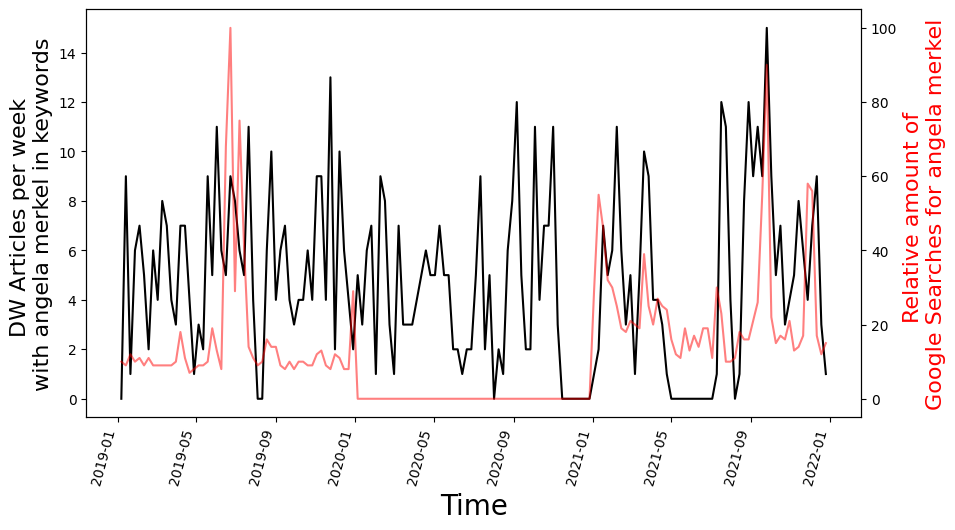

In [23]:
fig, ax = plt.subplots(figsize=(10,6))

plot_signals(mixed_df, fig, ax, keyword)